In [1]:
import bt
import FinanceDataReader as fdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns

# pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from IPython.display import display, HTML
"%config InlineBackend.figure_format = 'retina'"

#하나의 cell에서 multiple output을 출력을 가능하게 하는 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Pandas Dataframe의 사이즈가 큰 경우, 어떻게 화면에 출력을 할지를 세팅하는 코드
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from strategy import*
from utils import *

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [5]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)

In [12]:
oecd = pd.read_csv("data/OECD.csv", index_col=0, parse_dates=True).rename_axis("Date")
oecd

,전월비
Date,
2002-01-02,1.007
2002-02-01,1.007
2002-03-01,1.007
2002-04-01,1.006
2002-05-01,1.005
...,...
2020-03-01,1.001
2020-04-01,1.001
2020-05-01,1.001


## 한국 1. ID상대모멘텀
- **유니버스**
    - fnguide 섹터 인덱스
- **백테스팅 조건**
    - 섹터 인덱스의 6, 9, 12개월 수익률 평균값과 ID(직전 12개월의 월간 정보이산성)의 곱으로 상위 1개 섹터 선별
    - OECD 선행지표 (2개월 후행) 전월비 상승시 베팅, 하락시 현금 보유
- **월간 리밸런싱**

In [9]:
pdf = prices[:400].copy() # 백테스팅 디버깅을 위해 적은 데이터를 생성

In [7]:
def bt_SectorIDMomentum(name, n, tickers, prices):
    st = bt.Strategy(name,
                      algos = [
                          bt.algos.RunAfterDate('2002-1-2'),
                          bt.algos.RunMonthly(),
                          bt.algos.SelectAll(),
                          bt.algos.SelectThese(tickers),
                          StatIDMomentumScore(lag=pd.DateOffset(days=0)),
                          bt.algos.SelectN(n=n, sort_descending=True),
                          # bt.algos.PrintDate(),
                          bt.algos.WeighEqually(),
                          # bt.algos.PrintTempData(),
                          bt.algos.Rebalance()
                      ],
                     )
    return bt.Backtest(st, prices)

In [8]:
tickers = list(prices.columns[:-4])#+['현금']
bt_id1 = bt_SectorIDMomentum("base1.ID상대모멘텀", n=1, tickers=tickers, prices=prices)
bt_id2 = bt_SectorIDMomentum("base2.ID상대모멘텀", n=2, tickers=tickers, prices=prices)
bt_id3 = bt_SectorIDMomentum("base3.ID상대모멘텀", n=3, tickers=tickers, prices=prices)

In [9]:
r = bt.run(bt_id1, bt_id2, bt_id3)

In [10]:
r.set_date_range("2002-02-01")
r.display()

Stat                 base1.ID상대모멘텀    base2.ID상대모멘텀    base3.ID상대모멘텀
-------------------  --------------------  --------------------  --------------------
Start                2002-02-01            2002-02-01            2002-02-01
End                  2020-07-02            2020-07-02            2020-07-02
Risk-free rate       0.00%                 0.00%                 0.00%

Total Return         1682.11%              794.20%               884.07%
Daily Sharpe         0.52                  0.47                  0.51
Daily Sortino        0.82                  0.72                  0.78
CAGR                 16.93%                12.63%                13.22%
Max Drawdown         -69.87%               -63.15%               -60.86%
Calmar Ratio         0.24                  0.20                  0.22

MTD                  4.87%                 1.93%                 2.32%
3m                   51.31%                32.70%                26.46%
6m                   48.79%                20.23%

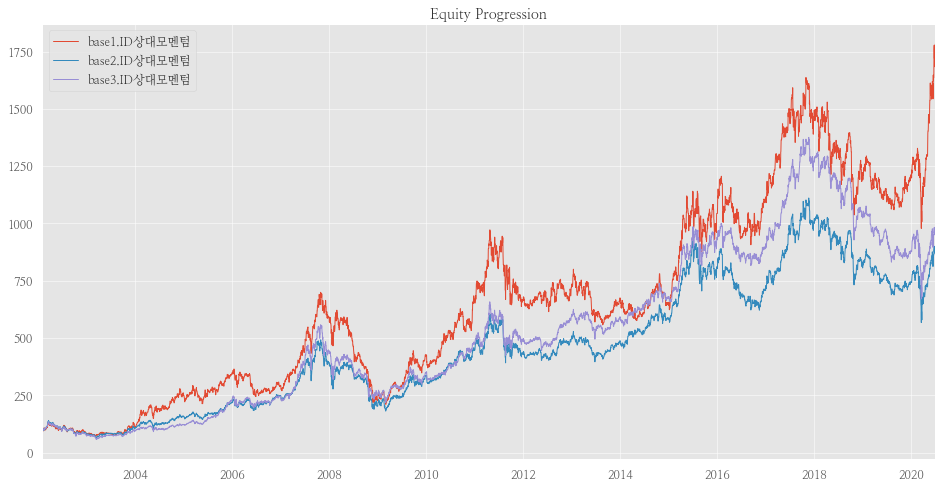

In [15]:
_=r.plot(figsize=(16,8))

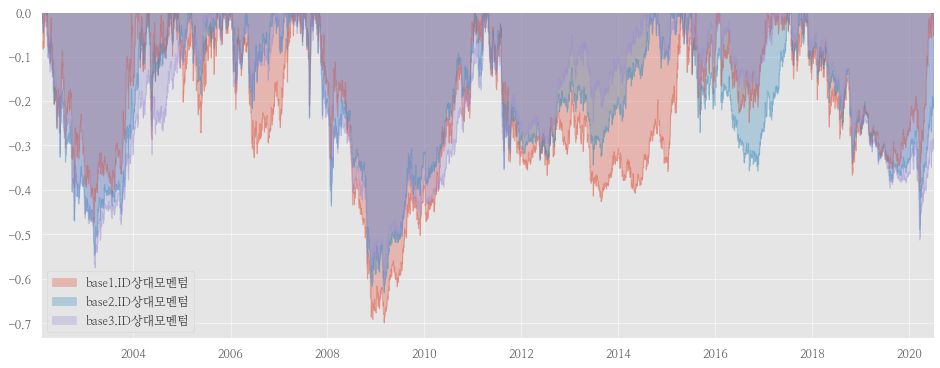

In [16]:
_=r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6))